# Binary Classification using two layer ANN - Bee or Not Bee

In this notebook we will implement a small Multi-layer Perceptron (MLP) to classify if an image shows a bee or not. The MLP will have two layers, and will use *NumPy* for the implementation.

***

**Objectives**

- Be able to implement **dense** and **sigmoid activation** layers
- Be able to design **neural network architectures** containing dense layers and sigmoid activation
- Be able to **forward** images through your neural network
- Be able to compute the **binary cross-entropy loss** for measuring the network's prediction error
- Be able to perform **backpropagation** using the chain rule

***

## 0 - Imports

In [1]:
archive = "DL_1.1.zip"
url = "https://cloud.tu-ilmenau.de/s/Pxoi3qEzzSd34Sk/download"
!wget -nv -t 0 --show-progress -O $archive $url
!unzip -j $archive

DL_1.1.zip              [  <=>               ]   6.36M  29.7MB/s    in 0.2s    
2023-11-22 21:54:42 URL:https://cloud.tu-ilmenau.de/s/Pxoi3qEzzSd34Sk/download [6666124] -> "DL_1.1.zip" [1]
Archive:  DL_1.1.zip
 extracting: ToBeeOrNotToBee_small_256px.zip  
 extracting: utils.py                


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from pathlib import Path

import utils

## 1 - Load Data

In [3]:
ds_name = "ToBeeOrNotToBee_small_256px"

with zipfile.ZipFile(f'{ds_name}.zip', 'r') as zip_ref:
    zip_ref.extractall('')

data_dir = Path(ds_name)

In [4]:
def load_images(directory, img_size=(128, 128)):

  images, labels = [], []

  directory_path = Path(directory)

  for filepath in directory_path.glob("**/*.jpg"):

    # load image
    img = Image.open(filepath)
    if img_size:
      img = img.resize(img_size)

    # append image
    images.append(np.array(img))

    # append label
    labels.append(filepath.parent.name)

  print(f"{directory} -> Found {len(images)} images for {len(np.unique(labels))} classes")

  # return images and labels
  return np.array(images), np.array(labels)

### TASK: Load the train, validation, and test images and labels

In [5]:
# load train, val, test images and labels
train_images, train_labels = load_images(data_dir.joinpath('train'))
val_images, val_labels = load_images(data_dir.joinpath('val'))
test_images, test_labels = load_images(data_dir.joinpath('test'))

ToBeeOrNotToBee_small_256px/train -> Found 289 images for 2 classes
ToBeeOrNotToBee_small_256px/val -> Found 90 images for 2 classes
ToBeeOrNotToBee_small_256px/test -> Found 98 images for 2 classes


In [6]:
# print unique labels
print(np.unique(train_labels))
print(set(train_labels))

['Bee' 'NoBee']
{'NoBee', 'Bee'}


Convert string labels to indices:

In [7]:
# define label mapping
label2index = {"NoBee":0, "Bee":1}
index2label = {index: label for label, index in label2index.items()}

# replace label "NoBee" with int(0) and "Bee" with int(1)
train_labels = np.array([label2index[label] for label in train_labels])
val_labels = np.array([label2index[label] for label in val_labels])
test_labels = np.array([label2index[label] for label in test_labels])

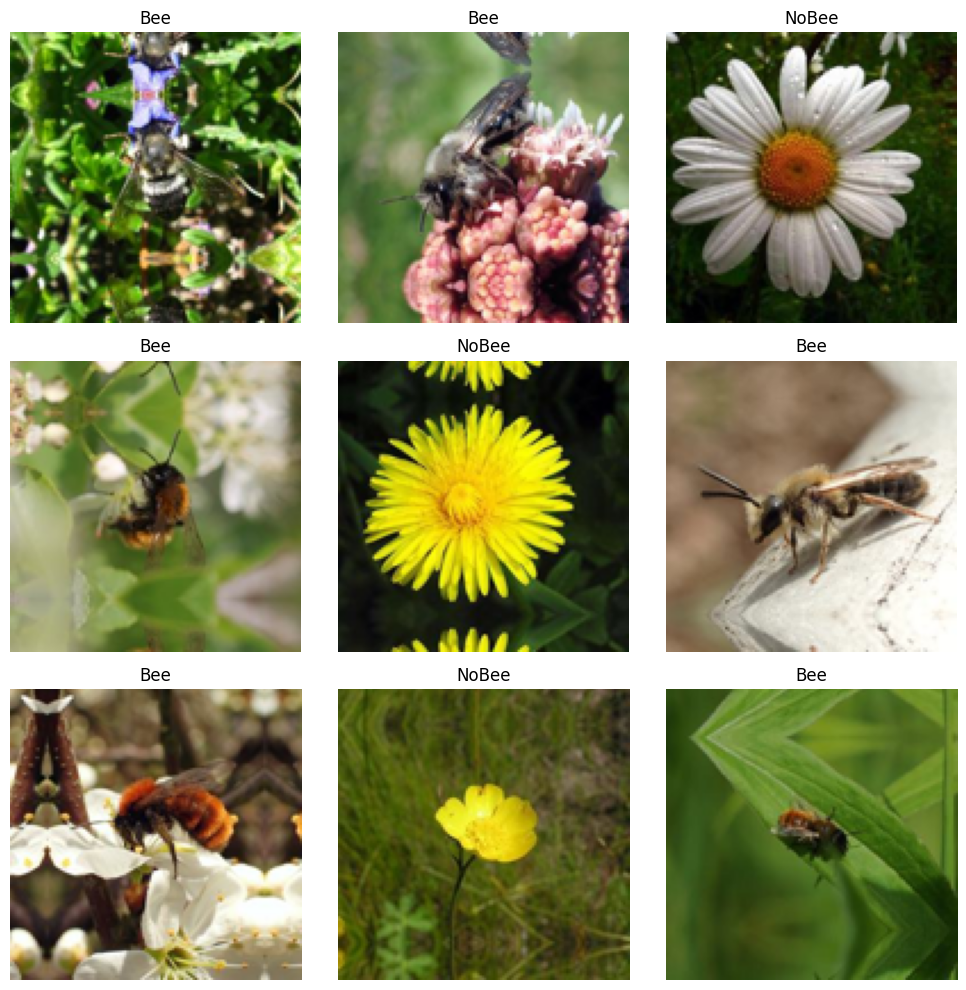

In [8]:
utils.show_images(train_images, train_labels, index2label)

In [9]:
print(train_images.shape)

(289, 128, 128, 3)


In [10]:
# flatten images and check the shapes
train_images_for_opt = utils.flatten_images(train_images)
val_images_for_opt = utils.flatten_images(val_images)
test_images_for_opt = utils.flatten_images(test_images)

for arr in [train_images_for_opt, val_images_for_opt, test_images_for_opt]:
  print(arr.shape)

(289, 49152)
(90, 49152)
(98, 49152)


In [11]:
# normalize images
train_images_for_opt = train_images_for_opt/255
val_images_for_opt = val_images_for_opt/255
test_images_for_opt = test_images_for_opt/255

## 2 - Initialize Parameters

We will use `np.random.randn()` for random initialization of parameters (`W1`, `b1`, `W2`, `b2`) for a two layer neural network. Multiply the initialized parameters with `sigma`.

In [12]:
def init_parameters(input_size, hidden_size, output_size):

  sigma = 0.01

  W1 = np.random.randn(hidden_size, input_size) * sigma
  b1 = np.random.randn(hidden_size, 1) * sigma

  W2 = np.random.randn(output_size, hidden_size) * sigma
  b2 = np.random.randn(output_size, 1) * sigma


  return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

### Test the initialization and check the shapes

Set `hidden_size` to `32`.

In [13]:
hidden_size = 32

parameters = init_parameters(train_images_for_opt.shape[1], hidden_size, 1)

for param in parameters:
  print(f"{param} shape: {parameters[param].shape}")

W1 shape: (32, 49152)
b1 shape: (32, 1)
W2 shape: (1, 32)
b2 shape: (1, 1)


## 3 - Implementing Activation Functions

Implement the `sigmoid` activation function and its derivative.

In [14]:
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

In [15]:
def sigmoid_derivative(A):
  return A * (1 - A)

## 4 - Implementing the Forward Propagation


Implement the `forward_propagation` function for a two layer neural network.

In [16]:
def forward_propagation(X, parameters):

  Z1 = np.dot(parameters["W1"], X) + parameters["b1"]
  A1 = sigmoid(Z1)

  Z2 = np.dot(parameters["W2"], A1) + parameters["b2"]
  A2 = sigmoid(Z2)

  # return output A2 along with intermediate computations ("cache")
  return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

## 4 - Implementing Loss Function

###Implement the binary cross entropy loss function

In [17]:
def binary_cross_entropy_loss(Y_hat, Y):
  loss = -Y * np.log(Y_hat) - (1 - Y) * np.log(1 - Y_hat)
  return loss

## 5 - Implementing the Backward Propagation

In [18]:
def backward_propagation(parameters, cache, X, Y):

  num_samples = X.shape[1]

  # second layer
  dZ2 = cache["A2"] - Y
  dW2 = np.dot(dZ2, cache["A1"].T) / num_samples
  db2 = np.sum(dZ2, axis=1, keepdims=True) / num_samples

  # first layer
  dZ1 = np.dot(parameters["W2"].T, dZ2) * sigmoid_derivative(cache["A1"])
  dW1 = np.dot(dZ1, X.T) / num_samples
  db1 = np.sum(dZ1, axis=1, keepdims=True) / num_samples

  # return gradients
  return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

## 6 - Implementing the Update

###Implement the `update_parameters` function

In [19]:
def update_parameters(parameters, gradients, learning_rate):
  parameters["W1"] -= learning_rate * gradients["dW1"]
  parameters["b1"] -= learning_rate * gradients["db1"]
  parameters["W2"] -= learning_rate * gradients["dW2"]
  parameters["b2"] -= learning_rate * gradients["db2"]
  return parameters

## 7 - Run the Optimization!

In [20]:
def optimize_step(X, Y, X_val, Y_val, parameters, learning_rate, verbose=True):

  metrics = {
      "loss":0,
      "val_loss":0,
      "accuracy":0,
      "val_accuracy":0
  }

  # forward
  cache = forward_propagation(X, parameters)

  # compute loss
  loss = binary_cross_entropy_loss(cache["A2"], Y)

  # backward propagation
  gradients = backward_propagation(parameters, cache, X, Y)

  # update parameters
  parameters = update_parameters(parameters, gradients, learning_rate)

  # compute metrics
  metrics["loss"] = np.mean(loss)
  metrics["accuracy"] = np.mean(np.round(cache["A2"]) == Y)

  # metrics on validation data
  cache_val = forward_propagation(X_val, parameters)
  metrics["val_loss"] = np.mean(binary_cross_entropy_loss(cache_val["A2"], Y_val))
  metrics["val_accuracy"] = np.mean(np.mean(np.round(cache_val["A2"]) == Y_val))

  if verbose:
    print(f"loss: {metrics['loss']:.3f}; validation_loss: {metrics['val_loss']:.3f}")
    print(f"accuracy: {metrics['accuracy']:.3f}; val_accuracy: {metrics['val_accuracy']:.3f}")

  return parameters, metrics

Initialize parameters

In [21]:
input_size = train_images_for_opt.shape[1]
hidden_size = 32
output_size = 1

learning_rate = 1e-1
parameters = init_parameters(input_size, hidden_size, output_size)

Now let us train network using Gradient Descent:

In [22]:
parameters, metrics = optimize_step(
    train_images_for_opt.T,
    train_labels,
    val_images_for_opt.T,
    val_labels,
    parameters,
    learning_rate
)

loss: 0.693; validation_loss: 0.696
accuracy: 0.550; val_accuracy: 0.289


Train for 100 epochs:

In [23]:
history = {
    "loss":[],
    "val_loss":[],
    "accuracy":[],
    "val_accuracy":[]
}

for epoch in range(100):

  parameters, metrics = optimize_step(
      train_images_for_opt.T,
      train_labels,
      val_images_for_opt.T,
      val_labels,
      parameters,
      learning_rate,
      verbose=False
  )

  print(f"Epoch: {epoch} - loss: {metrics['loss']:.3f}; validation_loss: {metrics['val_loss']:.3f}",
        f"; accuracy: {metrics['accuracy']:.3f}; val_accuracy: {metrics['val_accuracy']:.3f}",
        sep='')

  history["loss"].append(metrics["loss"])
  history["val_loss"].append(metrics["val_loss"])

  history["accuracy"].append(metrics["accuracy"])
  history["val_accuracy"].append(metrics["val_accuracy"])

Epoch: 0 - loss: 0.690; validation_loss: 0.696; accuracy: 0.554; val_accuracy: 0.300
Epoch: 1 - loss: 0.687; validation_loss: 0.695; accuracy: 0.588; val_accuracy: 0.422
Epoch: 2 - loss: 0.684; validation_loss: 0.692; accuracy: 0.640; val_accuracy: 0.500
Epoch: 3 - loss: 0.679; validation_loss: 0.688; accuracy: 0.720; val_accuracy: 0.611
Epoch: 4 - loss: 0.674; validation_loss: 0.683; accuracy: 0.772; val_accuracy: 0.678
Epoch: 5 - loss: 0.667; validation_loss: 0.674; accuracy: 0.799; val_accuracy: 0.711
Epoch: 6 - loss: 0.658; validation_loss: 0.664; accuracy: 0.834; val_accuracy: 0.733
Epoch: 7 - loss: 0.647; validation_loss: 0.651; accuracy: 0.865; val_accuracy: 0.756
Epoch: 8 - loss: 0.634; validation_loss: 0.635; accuracy: 0.869; val_accuracy: 0.767
Epoch: 9 - loss: 0.619; validation_loss: 0.618; accuracy: 0.889; val_accuracy: 0.778
Epoch: 10 - loss: 0.601; validation_loss: 0.599; accuracy: 0.893; val_accuracy: 0.800
Epoch: 11 - loss: 0.581; validation_loss: 0.579; accuracy: 0.903

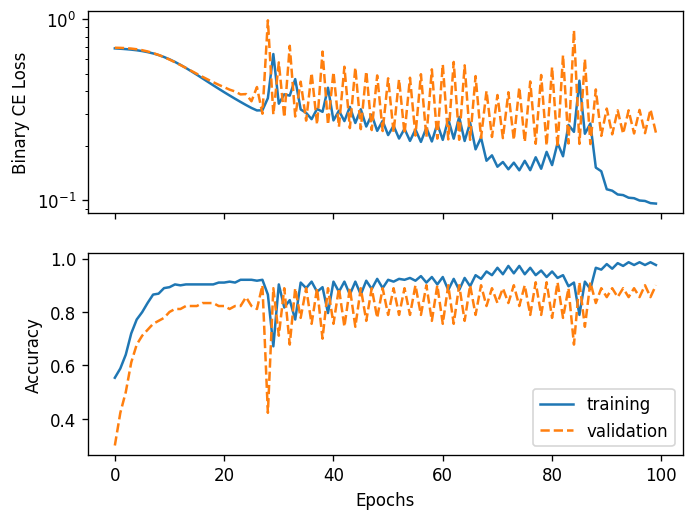

In [24]:
utils.plot_history(history)

---
This neural network made in NumPy is trained and it can be used to recognize bees in images.